Classification of DESC -> LABEL using CLIP text encoder + Logistic regression

Can we explain why sentences are missclassified ? 

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import clip

/home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/tidianes/miniconda3/envs/tid_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
!pwd

/media/tidianes/linux_home/tidiane/dev/nail/EEGClip/scripts/text_analysis


In [3]:
#calculation of clip embeddings
"""
data = pd.read_csv('data/TUH_Abnormal_EEG_rep.csv') #open the original dataset
tuh_data = data.drop([0]).dropna(subset=['DESCRIPTION OF THE RECORD']) #drop first line
tuh_data = tuh_data.rename(columns={"DESCRIPTION OF THE RECORD": "DESC"})


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, download_root="../data")

all_desc = tuh_data["DESC"].to_list()
all_desc_features = []

#get clip encodings of each description and write it in the dataset
with torch.no_grad():
    for desc in all_desc:
        desc_tokenized = clip.tokenize(desc, truncate = True).to(device)
        desc_features = clip_model.encode_text(desc_tokenized)

        all_desc_features.append(desc_features)

tuh_data["DESC_CLIP"] = torch.cat(all_desc_features).cpu().numpy().tolist()
tuh_data.to_csv("data/TUH_Abnormal_EEG_rep_clip_features.csv")
"""

'\ndata = pd.read_csv(\'data/TUH_Abnormal_EEG_rep.csv\') #open the original dataset\ntuh_data = data.drop([0]).dropna(subset=[\'DESCRIPTION OF THE RECORD\']) #drop first line\ntuh_data = tuh_data.rename(columns={"DESCRIPTION OF THE RECORD": "DESC"})\n\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nclip_model, preprocess = clip.load("ViT-B/32", device=device, download_root="../data")\n\nall_desc = tuh_data["DESC"].to_list()\nall_desc_features = []\n\n#get clip encodings of each description and write it in the dataset\nwith torch.no_grad():\n    for desc in all_desc:\n        desc_tokenized = clip.tokenize(desc, truncate = True).to(device)\n        desc_features = clip_model.encode_text(desc_tokenized)\n\n        all_desc_features.append(desc_features)\n\ntuh_data["DESC_CLIP"] = torch.cat(all_desc_features).cpu().numpy().tolist()\ntuh_data.to_csv("data/TUH_Abnormal_EEG_rep_clip_features.csv")\n'

In [4]:
#read the dataset with clip encodings
tuh_data = pd.read_csv('/home/tidianes/dev/nail/EEGClip/data/TUH/TUH_Abnormal_EEG_rep_clip_features.csv')
tuh_data["DESC_CLIP"] = [json.loads(l) for l in tuh_data["DESC_CLIP"]]

In [5]:
tuh_data

,Unnamed: 0,ID,PATH,SUBJECT,SESSION,SET,LABEL,ICD-10,IMPRESSION,DESC,...,HEART RATE,FINDINGS,REASON FOR STUDY,TECHNICAL DIFFICULTIES,EVENTS,CONDITION OF THE RECORDING,PAST MEDICAL HISTORY,TYPE OF STUDY,ACTIVATION PROCEDURES,DESC_CLIP
0,1,0.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,5864,s001_2009_09_03,eval,normal,NaN,Normal EEG.,"In wakefulness, background EEG is well organiz...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.17503206431865692, 0.06992441415786743, -0..."
1,2,1.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,4196,s003_2009_09_03,eval,normal,NaN,Normal electroencephalogram.,"In wakefulness, there is a 9.8 Hz alpha rhythm...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.2987368106842041, 0.019435854628682137, 0...."
2,3,2.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,5851,s001_2009_09_04,eval,normal,NaN,Normal EEG in wakefulness.,The background EEG is appropriately organized ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.10901573300361633, 0.04452670365571976, -0..."
3,4,3.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,929,s003_2009_09_04,train,normal,NaN,EEG within normal limits but excessively drows...,Digital video EEG is performed using standard ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.2441023886203766, -0.0048874616622924805, ..."
4,5,4.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,5909,s002_2009_09_09,train,normal,NaN,Normal EEG,In wakefulness there is a 9.5 Hz posterior dom...,...,66 bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.20705479383468628, 0.280615895986557, 0.08..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,2989,2988.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,7757,s003_2013_10_07,train,normal,NaN,Normal electroencephalogram in wakefulness and...,"In wakefulness, there is a 10.5 Hz alpha rhyth...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.12871378660202026, 0.20192506909370422, -0..."
2959,2990,2989.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,6091,s004_2013_10_07,eval,abnormal,NaN,"This is an abnormal EEG due to: 1. Discrete, f...","In wakefulness, there is a 9.5 Hz, 40 microvol...",...,60 bpm.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08205139636993408, -0.0922938659787178, 0...."
2960,2991,2990.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,9289,s004_2013_10_07,train,abnormal,NaN,Abnormal EEG due to: 1. Right temporal focal s...,"In wakefulness, there is a 10Hz alpha rhythm w...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.2395995855331421, -0.05268685892224312, 0...."
2961,2992,2991.0,/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2...,3240,s002_2013_10_10,train,normal,NaN,This is a normal EEG primarily in wakefulness.,The background EEG demonstrates an awake patte...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09678250551223755, 0.10995738953351974, 0...."


In [6]:
#classification using logistic regression

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,feature_selection, metrics
from sklearn.linear_model import LogisticRegression

tuh_train, tuh_test = model_selection.train_test_split(tuh_data, test_size=0.3)

train_features = tuh_train["DESC_CLIP"].to_list()
test_features = tuh_test["DESC_CLIP"].to_list()

train_labels = tuh_train["LABEL"].to_list()
test_labels = tuh_test["LABEL"].to_list()


classifier = LogisticRegression(random_state=0, max_iter=1000, verbose=0)
classifier.fit(train_features, train_labels)


classifier.fit(train_features, train_labels)
predictions = classifier.predict(test_features)
#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells



: 

: 

In [ ]:
#new column identifying the misclassified records
tuh_test["correct"]=(test_labels == predictions).astype(bool)


In [ ]:
#display 3 normal + correct
tuh_test[(tuh_test["correct"] == False) & (tuh_test["LABEL"] == "normal")]["DESC"].to_list()[:3]


In [ ]:
#display 3 abnormal + correct
tuh_test[(tuh_test["correct"] == True) & (tuh_test["LABEL"] == "abnormal")]["DESC"].to_list()[:3]

In [ ]:
#display 3 normal + incorrect
tuh_test[(tuh_test["correct"] == False) & (tuh_test["LABEL"] == "normal")]["DESC"].to_list()[:3]

In [ ]:
#display 3 abnormal + incorrect
tuh_test[(tuh_test["correct"] == False) & (tuh_test["LABEL"] == "abnormal")]["DESC"].to_list()[:3]

In [ ]:
#lists of description lengths for which correct = True
desc_len_true = tuh_test[tuh_test["correct"] == True]["DESC"].str.split().str.len().to_list()

#lists of description lengths for which correct = False
desc_len_false = tuh_test[tuh_test["correct"] == False]["DESC"].str.split().str.len().to_list()


#plot the normalized distributions of desc_len_true and desc_len_false on the same graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(desc_len_true, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3}, label = "correct")
sns.distplot(desc_len_false, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3}, label = "incorrect")
plt.legend(prop={'size': 16}, title = 'Correct')
plt.title('Distribution of description length')
plt.xlabel('Description length')
plt.ylabel('Density')





In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( stop_words='english', max_features=10000, ngram_range=(1,3))
tfidf_vector = tfidf_vectorizer.fit_transform(
    [tuh_test[tuh_test["correct"] == bool]["DESC"].str.cat(sep=' ')
     for bool in [True, False]])

tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=["correct","incorrect"], columns=tfidf_vectorizer.get_feature_names_out())



In [ ]:
tfidf_vector

In [ ]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [ ]:
import re

In [ ]:
#correct and incorrect classification
chained_sentences = [re.sub(r'[^A-Za-z0-9 ]+', '', tuh_test[tuh_test["correct"] == bool]["DESC"].str.cat(sep=' ').lower())
     for bool in [True, False]]

In [ ]:
#random
chained_sentences = [ re.sub(r'[^A-Za-z0-9 ]+', '', df["DESC"].str.cat(sep=' ').lower()) for df in model_selection.train_test_split(tuh_data, test_size=0.5)]

In [ ]:
#normal and abnormal label
chained_sentences = [ re.sub(r'[^A-Za-z0-9 ]+', '', tuh_data[tuh_data["LABEL"]==lbl]["DESC"].str.cat(sep=' ').lower() ) for lbl in ["abnormal", "normal"]]

In [ ]:
def word_frequency(text):
    #return a dictionary with the frequency of each word in the text without using nltk
    word_freq = {}
    for word in text.split() :
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    return word_freq



In [ ]:
freq_dicts = [word_frequency(d) for d in chained_sentences]
freq_lim = 50
#list of words that appear more than freq_lim times both dictionaries
common_words = [word for word in freq_dicts[0] if word in freq_dicts[1] and freq_dicts[0][word] > freq_lim and freq_dicts[1][word] > freq_lim]

#common_words = list(set( freq_dicts[0].keys() ) & set( freq_dicts[1].keys() )  )
common_words_relative_freq = []
for word in common_words:
    freq0 = freq_dicts[0][word]/sum(freq_dicts[0].values())
    freq1 = freq_dicts[1][word]/sum(freq_dicts[1].values())
    common_words_relative_freq.append( freq0 / freq1)
    


In [ ]:
sorted_relative_freq = [x for _, x in sorted(zip(common_words_relative_freq, common_words))]

In [ ]:
#print 10 first and last elements of sorted_relative_freq
print(sorted_relative_freq[:10])
print(sorted_relative_freq[-10:])

['early', 'seems', 'out', 'multiple', 'seconds', 'compared', 'although', 'symmetrical', 'for', 'from']
['transition', '40', 'defined', 'features', 'include', 'did', 'sections', 'awake', 'has', 'hertz']


Text(0, 0.5, 'Relative frequency')

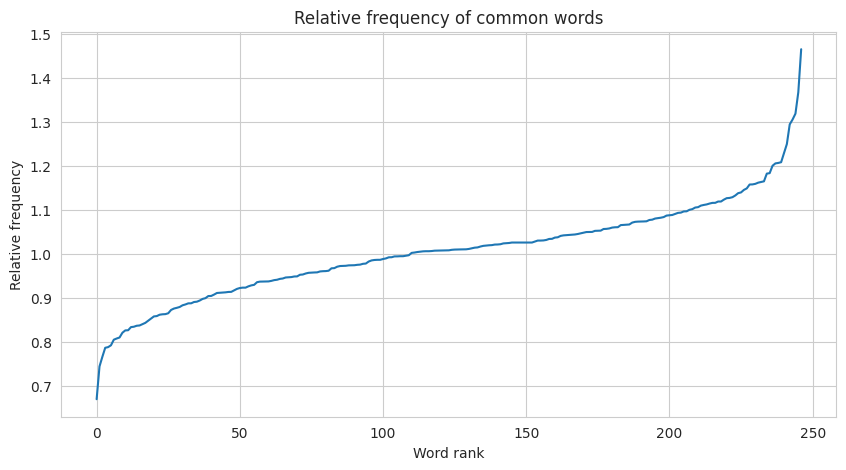

In [ ]:
#plot the sorted relative frequencies of the common words
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(sorted(common_words_relative_freq))
plt.title('Relative frequency of common words')
plt.xlabel('Word rank')
plt.ylabel('Relative frequency')


In [ ]:


from sklearn.manifold import TSNE

sentence_vec_tsne = TSNE(n_components=3).fit_transform(tuh_test['DESC_CLIP'].tolist())


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

fig = go.Figure(data=[go.Scatter3d(
    x=[a[0] for a in sentence_vec_tsne], # ie [0, 1, 2, 3]
    y=[a[1] for a in sentence_vec_tsne], # ie [0, 1, 2, 3]
    z=[a[2] for a in sentence_vec_tsne], # ie [0, 1, 2, 3]
    hovertemplate='<b>%{text}</b><extra></extra>',
    text = tuh_test["DESC"],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8,
        color=tuh_test["correct"].map({True:"red",False:"blue"}),
    )
)])

fig.show()



In [ ]:

tuh_t1, tuh_t2 = model_selection.train_test_split(tuh_test, test_size=0.3)

y_train = tuh_t1["correct"].values
corpus = tuh_t1["DESC"] #training corpus

#occurence table
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))
vectorizer.fit(corpus)

classifier = naive_bayes.MultinomialNB()
X_train = vectorizer.transform(corpus)

tfidf_model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])## train classifier
tfidf_model["classifier"].fit(X_train, y_train)

X_test = tuh_t2["DESC"].values
y_test = tuh_t2["correct"].values

predicted = tfidf_model.predict(X_test)
predicted_prob = tfidf_model.predict_proba(X_test)


100*metrics.accuracy_score(y_test, predicted)

In [ ]:
# learned coefficients weighted by frequency of appearance
average_feature_effects = classifier.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
feature_names = vectorizer.get_feature_names_out()
for i, label in enumerate(["yes", "no"]):
    top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
    if i == 0:
        top = pd.DataFrame(feature_names[top5], columns=[label])
        top_indices = top5
    else:
        top[label] = feature_names[top5]
        top_indices = np.concatenate((top_indices, top5), axis=None)

In [ ]:
average_feature_effects.shape